In [21]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
from spyglass.common import Session, IntervalList, Electrode, get_electrode_indices, interval_list_contains, interval_list_intersect
from spyglass.lfp.v1 import LFPV1
# from spyglass.lfp_band.v1 import LFPBandV1
from spyglass.position import PositionOutput
from spyglass.position.v1 import TrodesPosV1
from tqdm import tqdm

import os
os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/')
from ms_opto_stim_protocol import OptoStimProtocol,OptoStimProtocolParams, OptoStimProtocolTransfected, OptoStimProtocolLaser, OptoStimProtocolClosedLoop
from Analysis.utils import filter_animal, filter_task, filter_opto_data
from Analysis.lfp_analysis import get_ref_electrode_index, power_spectrum
from Analysis.position_analysis import filter_position_ports
from Style.style_guide import transfection_style


os.chdir('/home/sambray/Documents/MS_analysis/')
from ms_task_performance import AlternationTaskPerformance
from ms_dio_event import DioEvents, ProcessedDioEvents

from ms_task_identification import TaskIdentification
from ms_interval import EpochIntervalListName

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
track_type = "wtrack"
inbound_trial = []
trial_velocities = []
opto_trial = []
transfected_trial = []
accuracy = []
animal = ""



#################################
for transfected in [True,False]:
    dataset_key = {
                       # 'pulse_length_ms':40,
                       # "transfected":True,
                       "laser_power": 77,
                       'targeted_phase':90,
                        'animal':animal,
                        'transfected':transfected,
                        # "interval_list_name":"pos 3 valid times",
        }
    dataset = filter_opto_data(dataset_key)
    
    
    for nwb_file_name,interval_name in tqdm(zip(dataset.fetch("nwb_file_name"),dataset.fetch("interval_list_name"))):
        if nwb_file_name=='Bilbo20230802_.nwb' and interval_name=='pos 13 valid times':
            continue
        key = {"nwb_file_name":nwb_file_name,"interval_list_name":interval_name,}
        #outcomes and durations
        outcomes = ((AlternationTaskPerformance() * EpochIntervalListName)&key).fetch('performance_outcomes')
        if not len(outcomes):
            continue
        outcomes = outcomes[0]
        poke_times = ((ProcessedDioEvents().FirstUpPokes() * EpochIntervalListName)& key).fetch1("dio_first_poke_times")
        last_poke_times = ((ProcessedDioEvents().LastDownPokes() * EpochIntervalListName) & key).fetch1("dio_last_poke_times")
        inbound_trial.extend([('inbound' in x) for x in outcomes[1:]])
        accuracy.extend([('incorrect' in x) for x in outcomes[1:]])

        # speed
        pos_df = (TrodesPosV1() & key &  {"trodes_pos_params_name":"single_led"}).fetch1_dataframe()
        timestamps = np.array(pos_df.index)
        speed = np.asarray(pos_df.speed)
        trial_intervals = [[poke_times[i],poke_times[i+1]] for i in range(len(poke_times)-1)]
        travel_intervals = np.array(filter_position_ports(key))
        for trial in trial_intervals:
            intervals = interval_list_intersect(np.array(trial)[None,:], travel_intervals)
            if not len(intervals):
                trial_velocities.append(np.array([]))
                continue
            trial_velocities.append(np.concatenate([speed[np.where((timestamps>interval[0]) & (timestamps<interval[1]))[0]] for interval in intervals]))
    
        
        #Dio intervals
        test_intervals = (OptoStimProtocol() & key).fetch1("test_intervals")
        opto_trial.extend([interval_list_contains(test_intervals,np.array([i])).size for i in poke_times[1:]])

        #transfected
        transfected_trial.extend(np.ones(outcomes.size-1)*int(transfected))

# trial_durations = np.array(trial_durations)
inbound_trial = np.array(inbound_trial)
opto_trial = np.array(opto_trial).astype(bool)
transfected_trial = np.array(transfected_trial).astype(bool)
accuracy = ~np.array(accuracy).astype(bool)

datasets: 68


68it [00:16,  4.10it/s]


datasets: 54


54it [00:13,  3.99it/s]


In [11]:
# EpochIntervalListName() & key#{'nwb_file_name': 'Bilbo20230802_.nwb'}
# travel_intervals
filter_position_ports(key)

[]

Text(0, 0.5, 'outbound trials')

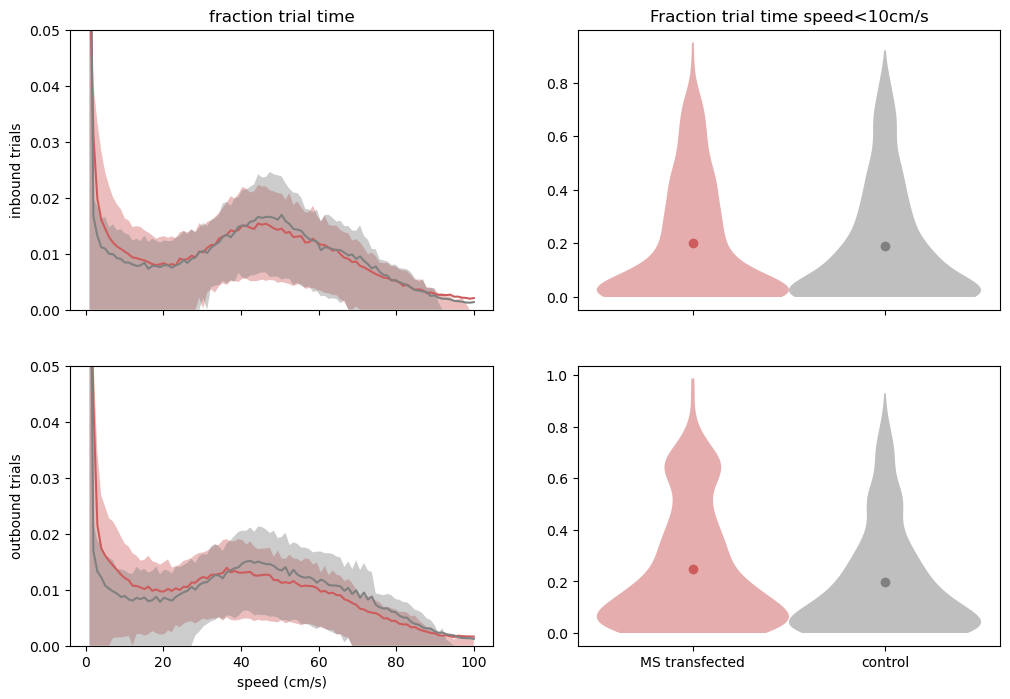

In [47]:
root_condition = (opto_trial)#& ~inbound_trial
speed_thresh = 10


fig,ax_list = plt.subplots(ncols = 2,nrows=2,figsize=(12,8),sharex='col')
for ii,trial_type in enumerate([inbound_trial,~inbound_trial]):
    base_condition = root_condition & trial_type
    ax = ax_list[ii]
    for i,(filter,color) in enumerate(zip([transfected_trial,~transfected_trial],transfection_style.values())):
        condition = base_condition & filter
        dist = []
        for velocity in np.array(trial_velocities)[np.where(condition)[0]]:
            velocity = velocity[~np.isnan(velocity)]
            val,bins = np.histogram(velocity,bins=np.linspace(0,100,100))
            if not val.sum():
                continue
            val = val/val.sum()
            dist.append(val)
        dist = np.array(dist)
        ax[0].plot(bins[1:],np.mean(dist,axis=0),c=color)
        ax[0].fill_between(bins[1:],np.nanpercentile(dist,25,axis=0),np.nanpercentile(dist,75,axis=0),facecolor=color,alpha=.4)
        #stationary time
        ind_stationary = np.where(bins<speed_thresh)[0]
        
        stationary_fract = np.nansum(dist[:,ind_stationary],axis=1)
        violin = ax[1].violinplot(stationary_fract,positions=[i/2],
                   showmedians=False,showextrema=False,points=1000,)
        for pc in violin['bodies']:
            pc.set_facecolor(color)
            pc.set_alpha(.5)
        ax[1].scatter([i/2],np.mean(stationary_fract),color = color)
        # break
ax_list[0,0,].set_ylim(0,.05)
ax_list[1,0,].set_ylim(0,.05)
ax[0].set_xlabel("speed (cm/s)")
ax_list[0,0].set_title("fraction trial time")
ax[1].set_xticks([0.,.5])
ax[1].set_xticklabels(["MS transfected","control"])
ax_list[0,1].set_title(f"Fraction trial time speed<{speed_thresh}cm/s")

ax_list[0,0].set_ylabel('inbound trials')
ax_list[1,0].set_ylabel('outbound trials')